<a href="https://colab.research.google.com/github/subhobrata/NLP_Exercises/blob/master/Week_01_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               
    100% |████████████████████████████████| 102kB 5.9MB/s 
    100% |████████████████████████████████| 17.3MB 2.7MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



There will have to authorize a request to Google Drive, sorry.


In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

    100% |████████████████████████████████| 993kB 19.9MB/s 


# Organizational

Course page: https://github.com/DanAnastasyev/DeepNLP-Course

Sample plan:

1. Introduction
2. PyTorch, word embeddings
3. RNN 1, text classification
4. RNN 2, sequence labeling
5. RNN 3, text generation, language models
6. CNN, text classification
7. Machine translation, attention
8. Transformers
9. Dialogue systems 1, tagging + classification, multi-task learning
10. Dialogue systems 2, DSSM
11. Transfer learning
12. Tensorflow + xla / aot or Meta BiLSTM (?)

... and something else


Text classification
Let's start with the simplest - analysis of the tonality of the text.

We will classify reviews from IMDB to positive / negative.

Dataset taken from http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [4]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Look at the texts with your eyes? What are the clues, how to determine what kind of sentiment?

The easiest, as always - to find keywords.

In [5]:
#@title Begin to classify! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 66.73%


** Task ** Make up good keywords or phrases and type at least 71% accuracy on the test (and don’t forget to look at the classification code!)

** Assignment ** Does anyone like these `<br /> <br />`? Personally, I do not. Write a regular calendar that will remove them

In [6]:
import re

pattern = re.compile(<smth>)

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

SyntaxError: ignored

Apply it:

In [7]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

NameError: ignored

t's time to go to the typewriter!

How will we present the text? The easiest thing - a bag of words.

Let's get a big-big dictionary - a list of all the words in the training set. Then each sentence can be represented as a vector in which it will be written, how many times each of the possible words has been encountered:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)


A simple and enjoyable way to do this is to stuff the texts into the `CountVectorizer`.

It has the following signature:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```


To begin with, pay attention to the parameters `lowercase = True` and` max_df = 1.0, min_df = 1, max_features = None` - they mean that by default all words will be converted to lower case and all words found in texts .

If desired, it would be possible to remove too rare or too frequent words - until we do this.

Let's look at a simple example of how it will work:

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


* How exactly does vectorizer define word boundaries? Note the parameter `token_pattern = r '(? U) \ b \ w \ w + \ b'` - how will it work? *

Run it on real data:

In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


Let's look at the words in the dictionary:

In [10]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1


Let's try to convert somebody

In [11]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 207 stored elements in Compressed Sparse Row format>


What they wanted was a vector with a bow (i.e. bag-of-words) representation of the source text.

And how can this information help? Well, all the same - some words are positive color, some - negative. Most are generally neutral, yes.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

I would like to probably choose the coefficients that will determine the level of color, right? It is necessary to select by the training sample, and not as we did before.

For example, for the sample
```
1   The movie was excellent
0   the movie was awful
```
It’s easy to pick odds on the eye: something like `+ 1` for` excellent`, `-1` for` awful` and zeros for everything else.

Let's build a linear model that will do this. She will learn to build a separating hyperplane in the space of bow-vectors.

Check out how the logistic regression can handle our super sample of a couple of sentences.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40105812  0.40105812  0.          0.          0.        ]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


It turned out that it is necessary.

Now run it on real data.

In [13]:
model.fit(train_df['review'], train_df['is_positive'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [14]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.67%



Progress!

I want to somehow see what interested the classifier. Fortunately, this is quite simple:

In [15]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.585,refreshing
+1.414,wonderfully
+1.345,erotic
+1.292,funniest
+1.288,excellent
+1.285,perfect
+1.267,superb
+1.262,carrey
+1.253,appreciated
+1.242,surprisingly


Let's look at specific examples of his work

In [16]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [17]:
print('Positive' if test_df['is_positive'].iloc[0] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[0], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Let's look at examples of incorrect classification, finally:

In [18]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

#We invent new signs

### Tf-idf


Now we look at all the words with the same weight - although some of them are more rare, some more frequent, and this frequency is useful, generally speaking, information.

The easiest way to add statistical information about frequencies is to do tf-idf weighing:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

* tf * - term-frequency - frequency of the word `t` in a specific document` d` (reviews in our case). This is exactly what we already thought.

* idf * - inverse document-frequency - the coefficient, which is greater, the smaller the number of documents encountered this word. It is considered something like this:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
where $ n_d $ is the number of all documents, and $ n_ {d (t)} $ is the number of documents with the word `t`.


Using it is easy - you need to replace `CountVectorizer` with` TfidfVectorizer`.

** Task ** Try running `TfidfVectorizer`. Look at the mistakes that he learned to correct, and the mistakes that he began to make - compared to `CountVectorizer`.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test accuracy = 88.31%


### N-grams of words

Until now, we looked at the texts as a bag of words - but it is obvious that there is a difference between the `good movie` and` not good movie`.

Add information (at least some) about the sequences of words - we will also extract the digrams of words.

In Vectorizers, this has the option `ngram_range = (n_1, n_2)` - it says that we need n_1 -... n_2-grams.

** Task ** Try increased range and interpret the result.

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test accuracy = 88.62%


### N-grams characters

Character n-grams provide an easy way to learn useful roots and suffixes without being associated with this linguistics of yours - just statistics, only hardcore.

For example, the word `badass` we can represent in the form of such a sequence of trigrams:

`## b #ba bad ada das ass ss # s ##`

So interpretable, is not it?

It’s still as easy to implement as you need to put an analyzer = 'char'` in your favorite Vectorizer and choose the size of `ngram_range`.

** Task ** Write down the classifier on n-grams of characters and visualize it.

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test accuracy = 87.66%


In [22]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## We connect linguistics

### Lemmatization and Stemming

If you look closely, you can find the forms of one word with different semantic coloring in the opinion of the classifier. Or not?

** Assignment ** Find the word forms with different semantic coloring.

Believe that they are, try something to do with it.

For example, lemmatizing - we will reduce all words to the initial form. The spacy library will help in this.

In [0]:
import spacy
from spacy import displacy

nlp = spacy.load('en', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [24]:
for token in docs[0]:
    print(token.text, token.lemma_)

Dreamgirls dreamgirl
, ,
despite despite
its -PRON-
fistful fistful
of of
Tony tony
wins win
in in
an an
incredibly incredibly
weak weak
year year
on on
Broadway broadway
, ,
has have
never never
been be
what what
one one
would would
call call
a a
jewel jewel
in in
the the
crown crown
of of
stage stage
musicals musical
. .
However however
, ,
that that
is be
not not
to to
say say
that that
in in
the the
right right
cinematic cinematic
hands hand
it -PRON-
could could
not not
be be
fleshed flesh
out out
and and
polished polish
into into
something something
worthwhile worthwhile
on on
- -
screen screen
. .
Unfortunately unfortunately
, ,
what what
transfers transfer
to to
the the
screen screen
is be
basically basically
a a
slavishly slavishly
faithful faithful
version version
of of
the the
stage stage
hit hit
with with
all all
of of
its -PRON-
inherent inherent
weaknesses weakness
intact intact
. .
First first
, ,
the the
score score
has have
never never
been be
one one
of of
the the
str


This whole process is very long, so I presupposed everything.

In [0]:
import pickle

with open('train_docs.pkl', 'rb') as f:
    train_docs = pickle.load(f)
    
with open('test_docs.pkl', 'rb') as f:
    test_docs = pickle.load(f)

** Task ** Make a classifier on lemmatized texts.

An easier way to normalize words is to use stemming. It is a little dull, does not take into account the context, but sometimes it turns out to be even more effective than lemmatization - and, most importantly, faster.

In essence, this is just a set of rules how to cut a word to get a stem (stem):

In [26]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


Task Try to classify bases instead of lemmas.

### NER

There are a lot of named entities in review texts. For example:

In [27]:
displacy.render(docs[0], style='ent', jupyter=True)


Generally speaking, why should any Depp have to carry a semantic coloring? However, it turns out that the classifier learns that some names are more often in positive reviews - or vice versa. It looks like retraining - why not try cutting out entities?

Task Remove some of the entities from the texts, using the coordinates from the stuffed files. Description of entities can be found here. Run the classifier.


## Turn on deep learning

We came here to do deep learning, and for some reason we are doing a logistic regression model. How so?

Let's try to launch a relatively standard model for text classification - a convolutional network on top of word embeddings.

Understand what kind of beast we will be in the next classes, but for now we will just use it :)

Each sentence must be represented by a set of words - and immediately the problems begin. First, how to limit the length of a sentence?

Let us estimate according to the histogram, which length suits us:

<a list of 219 Patch objects>

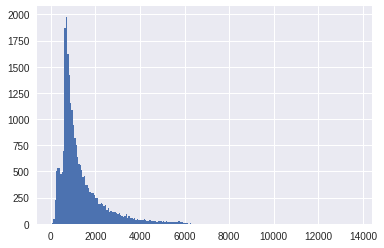

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text)), bins='auto')
hist

In addition, you need to renumber the words somehow.

In [32]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count 10 :
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

SyntaxError: ignored

**Задание** Сконвертируйте данные

In [0]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    <fill the matrix>
    return data

X_train = convert(train_df.review, word2idx, <your limit>)
X_test = convert(test_df.review, word2idx, <your limit>)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1),
    GlobalMaxPooling1D(),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

**Задание** Подсчитайте качество модели на тесте

## Немного математики

Вспомним, как работает логистическая регрессия, которой мы тут столько пользовались.

Пригодятся:

In [0]:
np.random.seed(42)
w, X, y = np.random.random(10), np.random.random((11, 10)), 2 * (np.random.randint(0, 2, 11) - 0.5)

Это обычная линейная функция

$$h_w(X) = \sigma(X w),$$
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Подсчитайте ее:

In [0]:
def forward(X, w):
    """ Функция, вычисляющая h(X, w)
    X - матрица (n, m)
    w - вектор (m,)
    """
    <calc h>

Функция потерь 
$$J(w)  = \frac{1}{m} \left(-y^T \text{log}(h_w) - (1-y)^T \text{log}(1 - h_w)\right)$$

Для оптимизации с SGD нужно считать градиент по функции потерь
$\frac{\partial J(w)}{\partial w}$.

**Задание** Подсчитайте их.

In [0]:
def loss(X, w, y):
    """ Функция потерь
    X - матрица (n, m)
    w - вектор (m,)
    y - вектор (n,)
    """
    <calc loss>


def gradient(X, w, y):
    """ Градиент функции потерь по w
    X - матрица (n, m)
    w - вектор (m,)
    y - вектор (n,)
    """
    <calc grad>


print('loss = ', loss(X, w, y))
print('gradient = ', gradient(X, w, y))

assert gradient(X, w, y).shape == w.shape

Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью конечных разностей: 

$$[\nabla f(x)]_i \approx \frac{f(x + \varepsilon \cdot e_i) - f(x)}{\varepsilon}$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\varepsilon \approx 10^{-8}$

In [0]:
def grad_finite_diff(func, x, eps=1e-8):
    """
    w - вектор (m,)
    func - скалярная функция от векторного аргумента w, func(w) = число
    eps - константа для проверки градиента
    """
    x, fval, dnum = x.astype(np.float64), func(x), np.zeros_like(x)
    
    E = np.eye(x.shape[0])
    deltas = np.array([func(x + eps * E[i]) for i in range(x.shape[0])])
    return (deltas - fval) / eps

mat_grad = gradient(X, w, y)
num_grad = grad_finite_diff(lambda w: loss(X, w, y), w)

err = np.max(np.abs(mat_grad - num_grad))
print('err = ', err, 'ok' if err < 1e-6 else 'ошибка очень большая =(')

В итоге получим такой класс:

In [0]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        self._w = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            grad = gradient(X, self._w, y)
            self._w -= self.lr * grad
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return forward(X, self._w)
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

Посмотрим, как всё работает на простых датасетах:

In [0]:
from sklearn.datasets import make_moons, load_iris

iris = load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1

model = LogisticRegression(lr=0.1, num_iter=300000)
model.fit(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
plt.legend()

x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
grid = np.c_[xx1.ravel(), xx2.ravel()]
probs = model.predict_prob(grid).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black')

In [0]:
X, y = make_moons(noise=0.1)

model = LogisticRegression()
model.fit(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
plt.legend()

x1_min, x1_max = X[:,0].min(), X[:,0].max()
x2_min, x2_max = X[:,1].min(), X[:,1].max()
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

grid = np.c_[xx1.ravel(), xx2.ravel()]

probs = model.predict_prob(grid).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black')

# Сдача задания

Сдаем через [форму](https://goo.gl/forms/TWl14R42ddDPvZLU2).

И можно заполнить [анонимный опрос](https://goo.gl/forms/RII9cRcwoaJjPr2G3).